In [44]:
# Import libraries
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from ipywidgets import Button, VBox, HBox, Output, Label
from IPython.display import display
import glob
from scipy import signal
from matplotlib import cm

In [45]:
# Define settings for Moon and Mars
settings = {
    'moon': {
        'low_freq_point': 0.2,#0.6
        'high_freq_point': 1,
        'frequence_window': 0.2,
        'sta_len': 100,
        'lta_len': 1000,
        'thr_on': 3,
        'resample': False
    },
    'mars': {
        'low_freq_point': 0.6,
        'high_freq_point': 4,
        'frequence_window': 0.5,
        'sta_len': 20,
        'lta_len': 80,
        'thr_on': 2.1,
        'resample': True
    }
}

# Function to get settings based on event type
def get_settings(event_type):
    return settings.get(event_type, settings['moon'])  # Default to 'moon' if event_type is not found

In [46]:
#mseed_files = sorted(glob.glob('./data/mars/training/data/*.mseed'))
mseed_files = sorted(glob.glob('./data/mars/test/data/*.mseed'))

#mseed_files = sorted(glob.glob('./data/lunar/training/data/S12_GradeA/*.mseed'))
#mseed_files = sorted(glob.glob('./data/lunar/test/data/S12_GradeB/*.mseed'))
#mseed_files = sorted(glob.glob('./data/lunar/test/data/S15_GradeA/*.mseed'))
#mseed_files = sorted(glob.glob('./data/lunar/test/data/S15_GradeB/*.mseed'))
#mseed_files = sorted(glob.glob('./data/lunar/test/data/S16_GradeA/*.mseed'))
#mseed_files = sorted(glob.glob('./data/lunar/test/data/S16_GradeB/*.mseed'))

event_info = []
filename = ''


# Determine event type based on the file path
if 'lunar' in mseed_files[0]:
    event_type = 'moon'
elif 'mars' in mseed_files[0]:
    event_type = 'mars'
else:
    event_type = 'moon'  # Default to 'moon' if neither is found

# Get settings based on the determined event type
current_settings = get_settings(event_type)
plot = True

In [47]:
def load_mseed(file_idx):
    st = read(mseed_files[file_idx])
    return st, mseed_files[file_idx]



def calculate_best_freq_range_by_std(st, resample):
    # Define frequency ranges for filtering
    freq_ranges = [
          (start, start + current_settings['frequence_window']) 
          for start in np.arange(
              current_settings['low_freq_point'], 
              current_settings['high_freq_point'], 
              0.1)]
    
    stddev_in_ranges = []
    for f_min, f_max in freq_ranges:
        # Copy the original trace for filtering
        st_filt = st.copy()
        # Apply bandpass filter for the given frequency range
        st_filt.filter('bandpass', freqmin=f_min, freqmax=f_max)
        # Extract the filtered trace data
        tr_filt = st_filt.traces[0].copy()
        #if(resample):
            #tr_filt.resample(6.625)
        tr_data_filt = tr_filt.data
        # Normalize tr_data_filt between -1 and 1
        tr_data_filt = 2 * (tr_data_filt - np.min(tr_data_filt)) / (np.max(tr_data_filt) - np.min(tr_data_filt)) - 1
        
        # Calculate standard deviation of the filtered signal
        stddev = np.std(tr_data_filt)
        stddev_in_ranges.append((f_min, f_max, stddev))
    # Find the frequency range with the minimum standard deviation
    best_range = min(stddev_in_ranges, key=lambda x: x[2])

    print(f"The best frequency range is {best_range[0]:.1f} to {best_range[1]:.1f} with minimum standard deviation {best_range[2]:.3f}")
    return best_range 

def calculate_best_freq_range_by_pwr(st, resample):
    # Extract the trace data and sampling rate
    tr = st.traces[0].copy()
    sampling_rate = tr.stats.sampling_rate
    tr_data = tr.data

    # Define frequency ranges for filtering
    freq_ranges = [
        (start, start + current_settings['frequence_window']) 
        for start in np.arange(
            current_settings['low_freq_point'], 
            current_settings['high_freq_point'],
            0.1
        )
    ]
    # Initialize list to store top 1000 power averages for each frequency range
    max_power_in_ranges = []

    # Loop through each frequency range
    for f_min, f_max in freq_ranges:
        # Copy the original trace for filtering
        st_filt = st.copy()

        # Apply bandpass filter for the given frequency range
        st_filt.filter('bandpass', freqmin=f_min, freqmax=f_max)

        # Extract the filtered trace data
        tr_filt = st_filt.traces[0].data

        # Compute the spectrogram for the filtered signal
        fu, tu, sxxu = signal.spectrogram(tr_filt, fs=sampling_rate)
        sxxu_dB = 10 * np.log10(sxxu)

        # Flatten the entire spectrogram (all frequencies and time points)
        power_values_flat = sxxu_dB.flatten()

        # Sort the power values and take the top 1000
        top_1000_power_values = np.sort(power_values_flat)[-50:]  # Top 1000 largest values

        # Calculate the average of the top 1000 values
        top_1000_avg_power = np.mean(top_1000_power_values)
        print(top_1000_avg_power)

        # Store the frequency range and the calculated average power
        max_power_in_ranges.append((f_min, f_max, top_1000_avg_power))

    # Find the frequency range with the greatest average of the top 1000 power values
    best_range = max(max_power_in_ranges, key=lambda x: x[2])

    print(f"The best frequency range is {best_range[0]:.1f} to {best_range[1]:.1f} with average power {best_range[2]:.3f}")
    return best_range




In [48]:
current_file_idx = 0    
def detect_events(max_files = 100):
    num_files_to_display = len(mseed_files)
    if(num_files_to_display > max_files):
        num_files_to_display = max_files

    print('Detecting events.....')
    print('Event Type is :', event_type)
    if(plot):
        # Create a vertical plot layout based on the number of files (each file gets 4 plots)
        fig, axs = plt.subplots(num_files_to_display, 2, figsize=(20, 5 * num_files_to_display))
    resample = current_settings['resample']
    event_number = 0
    for i in range(num_files_to_display):
        global filename
        # Load the MiniSEED file
        st, filename = load_mseed(current_file_idx + i)  # Incrementing file index
        # Extract the evid part from the filename
        evid = filename.split('_')[-1].split('.')[0]
        filename = filename
        
        
        #best_range = calculate_best_freq_range_by_std(st, resample)
        best_range = calculate_best_freq_range_by_pwr(st, resample)
        # Define the frequency range for the bandpass filter
        # minfreq = 0.8
        # maxfreq = 0.9
        minfreq = best_range[0]
        maxfreq = best_range[1]

        # ============================Apply the filter
        st_filt = st.copy()
        st_filt.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
        #st_filt.filter('bandpass', freqmin=3, freqmax=4)
        if(resample):
            st_filt.resample(6.625)
        tr_filt = st_filt.traces[0].copy()
        tr_times_filt = tr_filt.times()
        tr_data_filt = tr_filt.data
        stddev = np.std(tr_data_filt)
        threshold_upper = 26 * stddev
        threshold_lower = -26 * stddev
        tr_data_filt[np.abs(tr_data_filt) > threshold_upper] = stddev 
        tr_data_filt[np.abs(tr_data_filt) < threshold_lower] = -stddev
        # Normalize tr_data_filt between -1 and 1
        tr_data_filt = 2 * (tr_data_filt - np.min(tr_data_filt)) / (np.max(tr_data_filt) - np.min(tr_data_filt)) - 1

        from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

        sta_len = current_settings['sta_len']
        lta_len = current_settings['lta_len']

        tr_data_abs = np.abs(tr_data_filt)
        df = 6.625
        # Run Obspy's STA/LTA to obtain a characteristic function
        cft = classic_sta_lta(tr_data_abs, int(sta_len * df), int(lta_len * df))
        average_cft = np.mean(cft)
        print(f'Average CFT: {average_cft}')

        thr_on = current_settings['thr_on']
        thr_off = average_cft
        on_off = np.array(trigger_onset(cft, thr_on, thr_off))


        cat_directory = './data/lunar/training/catalogs/'
        cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
        cat = pd.read_csv(cat_file)
        row = cat.iloc[i]
        arrival_time_rel = row['time_rel(sec)']

        if(plot):
            # Plot filtered trace in the first column
            axs[i, 0].plot(tr_times_filt, tr_data_filt)
            axs[i, 0].set_xlim([min(tr_times_filt), max(tr_times_filt)])
            axs[i, 0].set_ylabel('Velocity (m/s)')
            axs[i, 0].set_xlabel('Time (s)')
            axs[i, 0].set_title(f'Filtered Time Series of {evid} with {i}')
            arrival_line = axs[i, 0].axvline(x=arrival_time_rel, c='purple', label='Abs. Arrival')
            axs[i, 0].annotate(f'Arrival TIme at {arrival_time_rel}', xy=(arrival_time_rel, tr_data_filt.max()), 
                            xytext=(arrival_time_rel + 0.1, tr_data_filt.max()+0.1),  # Adjust text position
                            color='black', fontsize=11)
            for j in np.arange(0, len(on_off)):
                triggers = on_off[j]
                if(triggers[1] - triggers[0] > 1200) or (len(on_off) < 30):
                    event_number += 1
                    exact_filename = filename.split('\\')[-1].rsplit('.', 1)[0]
                    event_info.append([exact_filename, event_number, f'{i} | {j}', (round(tr_times_filt[triggers[0]]-100)), 0, round(best_range[0],1), round(best_range[1],1),  ])
                    # Draw the vertical line
                    axs[i, 0].axvline(x=tr_times_filt[triggers[0]], color='red', label=f'Trig. On {j+1}')
                    #print(f'Trig. On {i+1} of {j+1} at {triggers[0]}')
                    # Annotate with the trigger number (or any custom label)
                    dj = (j - 1) % 16 + 1
                    axs[i, 0].annotate(f'Trig {event_number} at {round(tr_times_filt[triggers[0]])}s', xy=(tr_times_filt[triggers[0]], tr_data_filt.max()), 
                                    xytext=(tr_times_filt[triggers[0]] + 0.1, tr_data_filt.max()-(dj/8)),  # Adjust text position
                                    color='grey', fontsize=11)

            # Plot characteristic function
            axs[i,1].plot(tr_times_filt,cft)
            axs[i,1].set_xlim([min(tr_times_filt),max(tr_times_filt)])
            axs[i,1].set_xlabel('Time (s)')
            axs[i,1].set_ylabel('Characteristic function')

        
    if(plot):
        # Adjust layout for better spacing
        plt.tight_layout()
        plt.show()

Detecting events.....
Event Type is : mars
40.795303165224
38.64558787094606
36.597112745460365
36.33208587929295
33.64745753641588
31.200932528265124
31.591797662342483
31.620848759729625
31.58933506138693
31.530158414039075
31.21783892932649
31.301056245179616
31.32243735534543
31.534516515002778
31.599603517756886
31.75184559072185
31.85465684878571
33.23164823179761
33.52462617642499
33.48099307364333
33.409727700324055
32.44123685954969
33.69375598521678
36.67711541386824
37.014775032162035
37.02502391804571
37.03782971423661
35.619390791077954
34.60391425400026
35.30144281907765
39.96704525864936
41.958630884765114
42.074205360678036
42.07890001350874
The best frequency range is 3.9 to 4.4 with average power 42.079
Average CFT: 0.9855162421232709
37.19359437387069
36.14778184258901
35.482623373829846
35.189917780050045
32.28059800376348
22.53997016225297
22.6063767374198
23.625802930483438
24.514613356038286
25.25475095210164
26.276402442844788
26.80131015870227
27.37158641217280

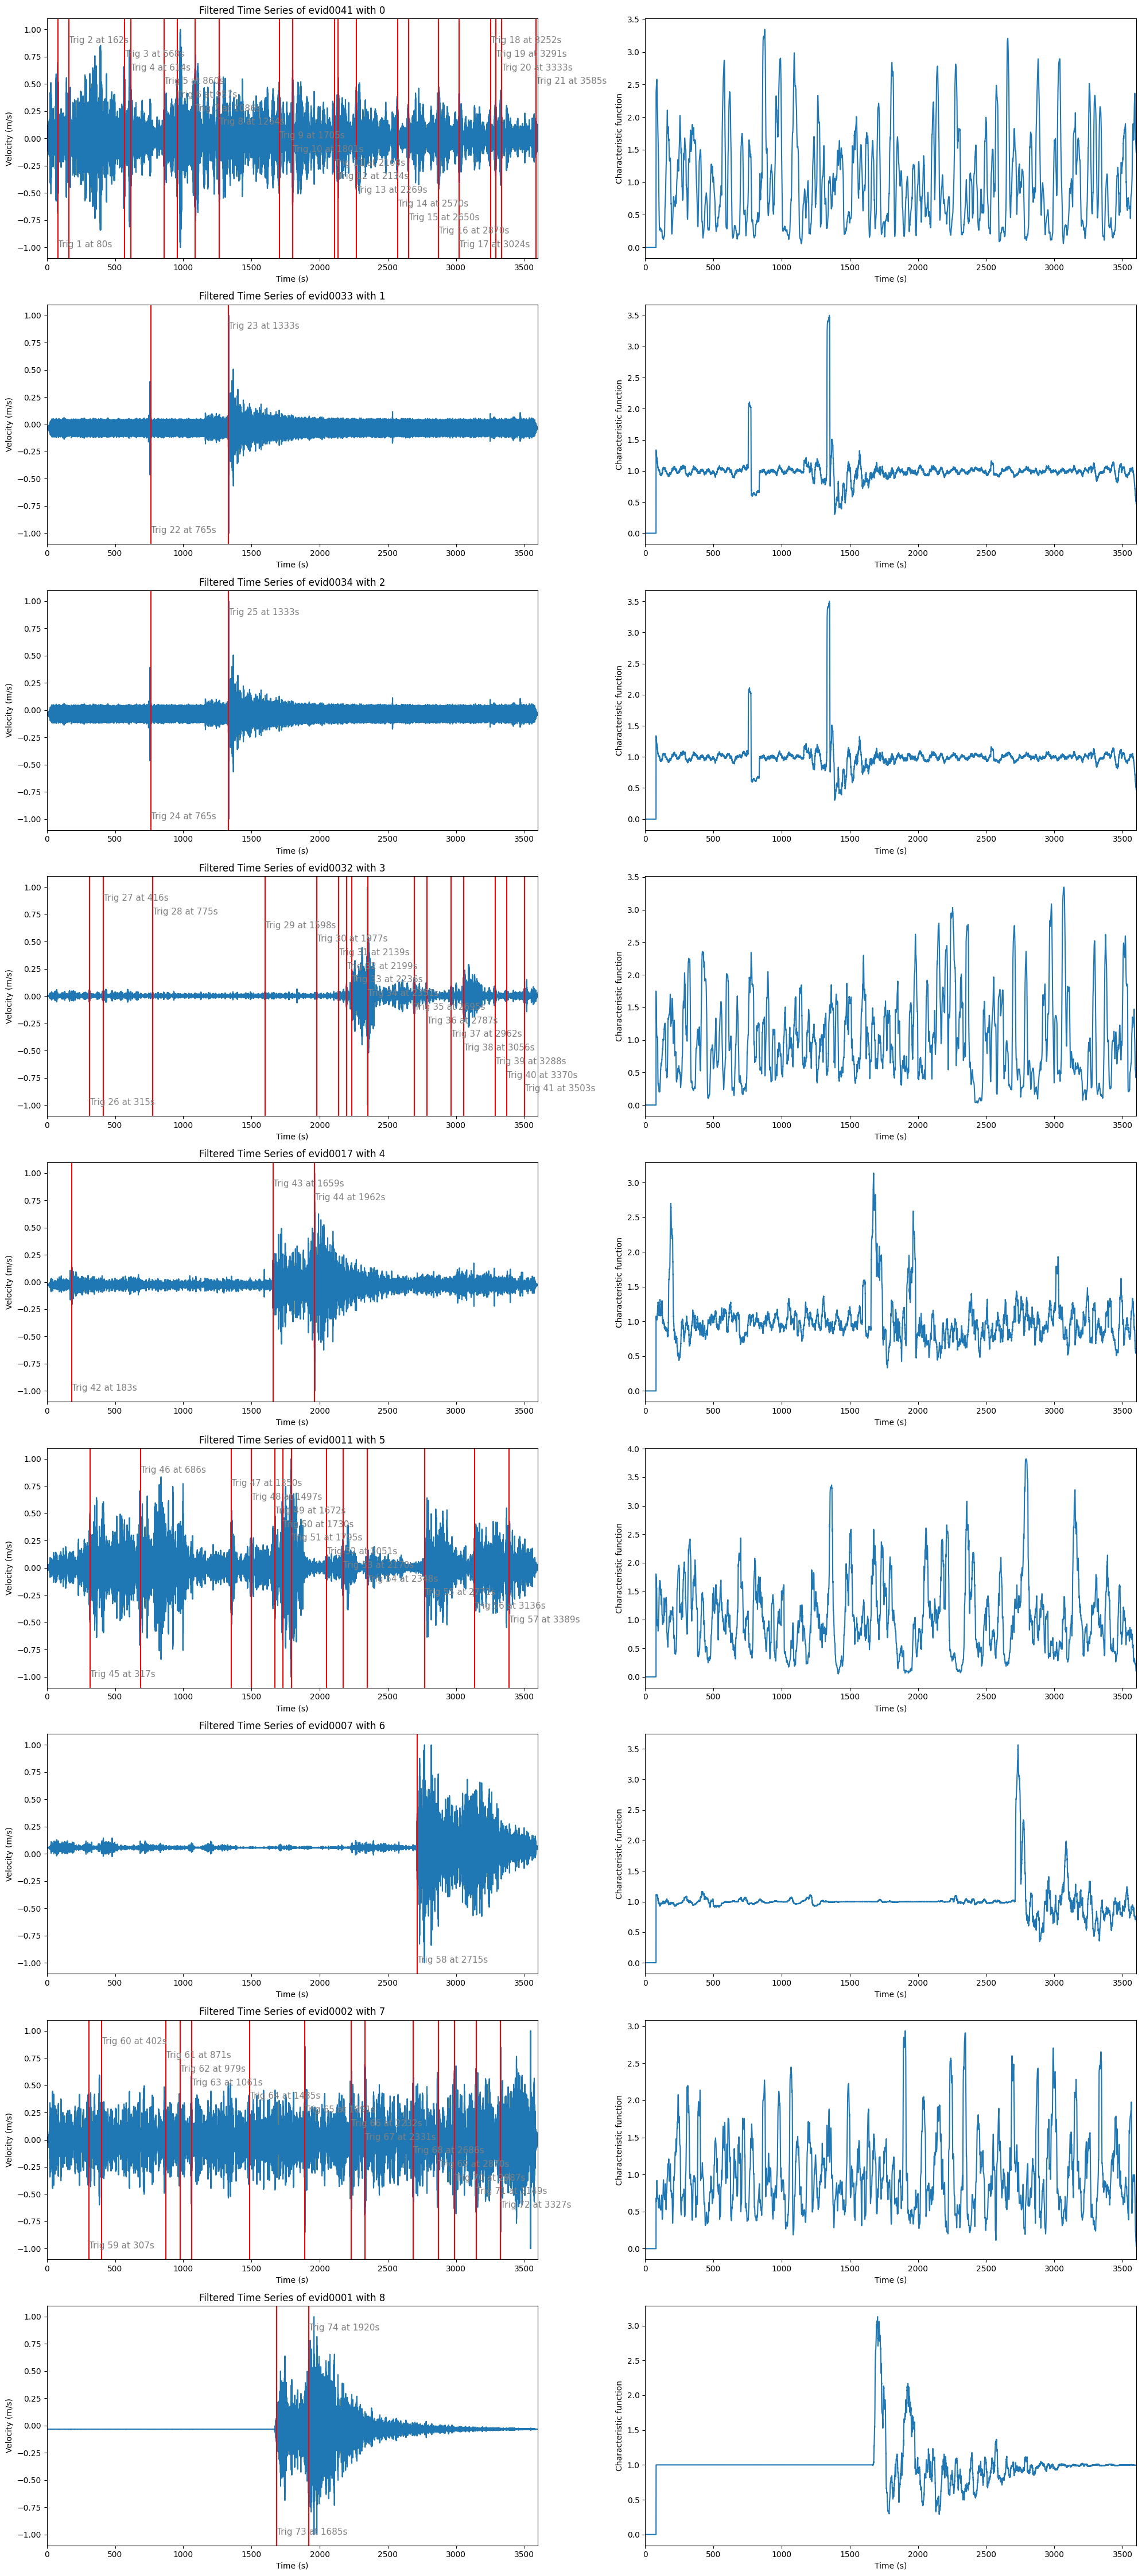

In [49]:

detect_events(max_files = 100)

## Make Catalog File

In [50]:
folder_name = filename.split('/')[-1].split('\\')[0]
# Convert the event information list to a DataFrame
event_df = pd.DataFrame(event_info, columns=['filename', 'Event Number','events_in_day(day|event)', 'time_rel(sec)', 'time_abs(sec)', 'Filter_low_freq_point', 'Filter_high_freq_point'])
event_df.to_csv(f'initial_filtered_events_of_{folder_name}.csv', index=False)